In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
np.random.seed(20030427)

In [2]:
def simulate_GBM(T,n_steps,X0,sigma):
    """
    Generate Efficient Price Using GBM (BS)
    T: Time Horizon
    n_steps: Number of time steps
    X0: Initial price
    sigma: Volatility
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    log_X = np.log(X0) - 0.5 * sigma**2 * t + sigma * np.cumsum(dW)
    X = np.exp(log_X)
    return t, X

In [3]:
def simulate_observed_price(T,n_steps, X0,sigma,alpha,eta):
    t, X = simulate_GBM(T,n_steps,X0,sigma)
    # Generate Traded/Observed Price P
    P = np.zeros_like(X)
    # The first observation price
    P[0] = np.round(X[0] / alpha) * alpha 
    change_indices = [0] 

    for i in range(1, n_steps):
        # Compute mid price M_i (middle of two nearest ticks)
        k = np.round(X[i] / alpha)
        mid_price = (k + 0.5) * alpha  # Mid price between two adjacent ticks
        
        # Compute uncertainty zone boundaries based on mid price
        lower = mid_price - alpha * (eta)
        upper = mid_price + alpha * (eta)

        if X[i] < lower or X[i] > upper:
            P[i] = np.round(X[i] / alpha) * alpha  # Snap to nearest tick
            change_indices.append(i)  # Mark price change
        else:
            P[i] = P[i-1]  # Price remains unchanged

    change_indices.append(n_steps - 1)
    return t, X, P, change_indices

In [4]:
def plot_uncertainty_zone_matplotlib(T,n_steps, X0,alpha, eta,sigma,seed=20030427):
    np.random.seed(seed)
    t, X, P, change_indices = simulate_observed_price(T,n_steps,X0,sigma,alpha,eta)
    fig, ax = plt.subplots(figsize=(16, 6))

    # 1. Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=2)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # 2. Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(n_steps):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # 3. Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    # 4. Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        mid_price_at_start = mid_prices[start]
        lower_at_start = mid_price_at_start - alpha * (eta)
        upper_at_start = mid_price_at_start + alpha * (eta)

        shaded_lower[start:end] = lower_at_start
        shaded_upper[start:end] = upper_at_start + alpha

    # Fill shaded area **evenly**
    ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)

    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)

    # Show plot
    plt.show()

    

In [5]:
alpha = 0.05      # Tick size
eta = 0.2        # Uncertainty zone width
T = 1.0          # Time horizon
sigma = 0.02 /np.sqrt(252)     # Volatility
X0 = 100.0       # Initial price
n_steps = 500   # Number of time steps

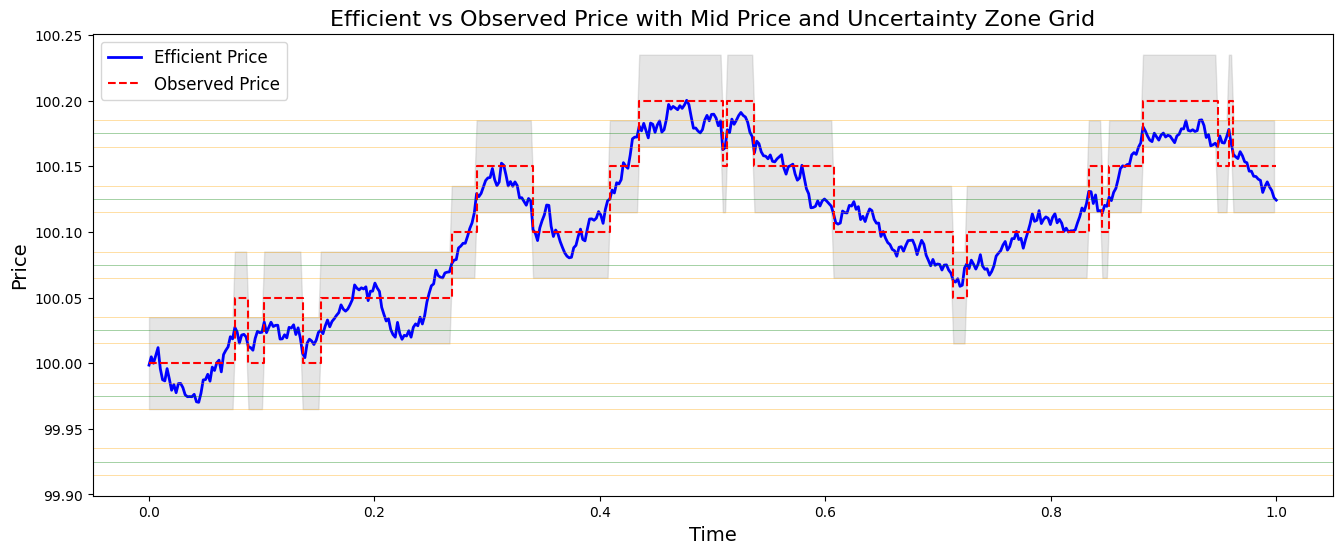

In [6]:
plot_uncertainty_zone_matplotlib(T,n_steps,X0,alpha,eta,sigma)

In [7]:
def plot_uncertainty_zone_seaborn(T,n_steps, X0,alpha, eta,sigma,seed=20030427):
    np.random.seed(seed)
    t, X, P, change_indices = simulate_observed_price(T,n_steps,X0,sigma,alpha,eta)
# Set seaborn style
    sns.set_style("whitegrid")

    # Initialize plot
    plt.figure(figsize=(16, 6))

    # 1. Plot efficient price and observed price
    sns.lineplot(x=t, y=X, label="Efficient Price", color="blue", linewidth=2)
    sns.lineplot(x=t, y=P, label="Observed Price", color="red", linestyle="--", linewidth=1.5, drawstyle="steps-post")

    # 2. Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(n_steps):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * ( eta)
        upper_bounds[i] = mid_prices[i] + alpha * ( eta)

    # 3. Plot mid price as a line
    #sns.lineplot(x=t, y=mid_prices, label="Mid Price", color="green", linestyle=":", linewidth=1.5)

    # 4. Add grid lines at all mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)  # Get unique mid price levels
    all_lower_bounds = np.unique(lower_bounds)  # Get unique lower bounds
    all_upper_bounds = np.unique(upper_bounds)  # Get unique upper bounds


    # Draw horizontal grid lines for each level
    for level in all_mid_prices:
        plt.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_lower_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_upper_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        mid_price_at_start = mid_prices[start]
        lower_at_start = mid_price_at_start - alpha * (eta)
        upper_at_start = mid_price_at_start + alpha * (eta)
        shaded_lower[start:end] = lower_at_start
        shaded_upper[start:end] = upper_at_start+alpha

        # Shaded area for uncertainty zones
        #plt.fill_between(t[start:end], lower_at_start, upper_at_start+alpha, color="gray", alpha=0.2)
        plt.fill_between(t, shaded_lower, shaded_upper, color="lightgray", alpha=0.1)

        # Vertical lines at price change points
        #plt.axvline(x=t[start], color="gray", linestyle=":", linewidth=0.5, alpha=0.5)



    # Labels and title
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    plt.legend(fontsize=12)

    # Show plot
    plt.show()



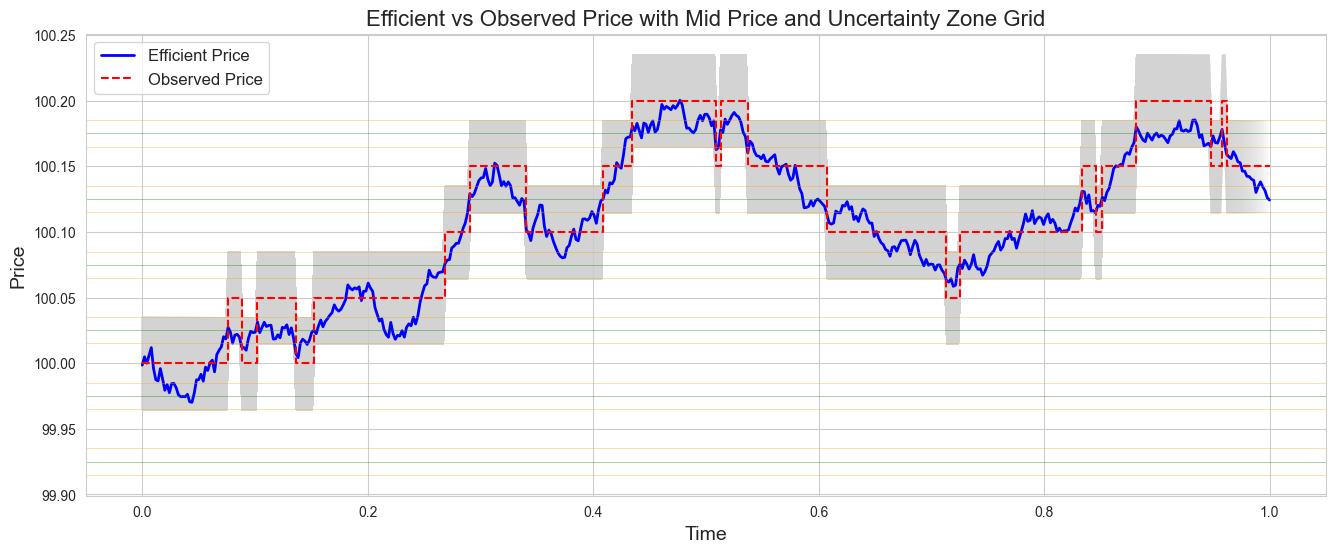

In [8]:
plot_uncertainty_zone_seaborn(T,n_steps,X0,alpha,eta,sigma)

In [9]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the BS price and delta of a European call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  
    return call_price, delta